In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imagesaegpred/rajni.jpg
/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv


# Table of content
1. [Importing relevent libraries](#01)
2. [Loading Dataset](#02)
3. [Distributions](#03)
    - [Age Distribution](#3.1)
    - [Ethnicity Distribution](#3.2)
    - [Gender Distribution](#3.3)
    - [Gender Distribution](#3.3)
    - [Sample Images](#3.4)
4. [Model for Gender Prediction](#04)
    - [Spliting data into train/test](#4.1)
    - [Build and train model](#4.2)
    - [Evaluating training history](#4.3)
5. [Model for Age Prediction](#06)
    - [Spliting data into train/test](#6.1)
    - [Build and train model](#6.2)
    - [Evaluating training history](#6.3)

## Importing relevent libraries <a id="01"></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls

data  gdrive  sample_data


In [5]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

## Loading Dataset <a id="02"></a>

In [6]:
data = pd.read_csv('gdrive/MyDrive/age_gender.csv')

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [7]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 23705
Total columns: 5


## Distributions <a id="03"></a>

In [8]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts().rename(index={0:'White',1:'Black',2:'Asian', 3:'Indian', 4:'Others'})
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

### Age Distribtion <a id="3.1"></a>

In [9]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

### Ethnicity Distribution <a id="3.2"></a>

In [10]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

### Gender Distribution <a id="3.3"></a>

In [11]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

In [12]:
X = np.array(data['pixels'].tolist())
#converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

### Sample Images <a id="3.4"></a>

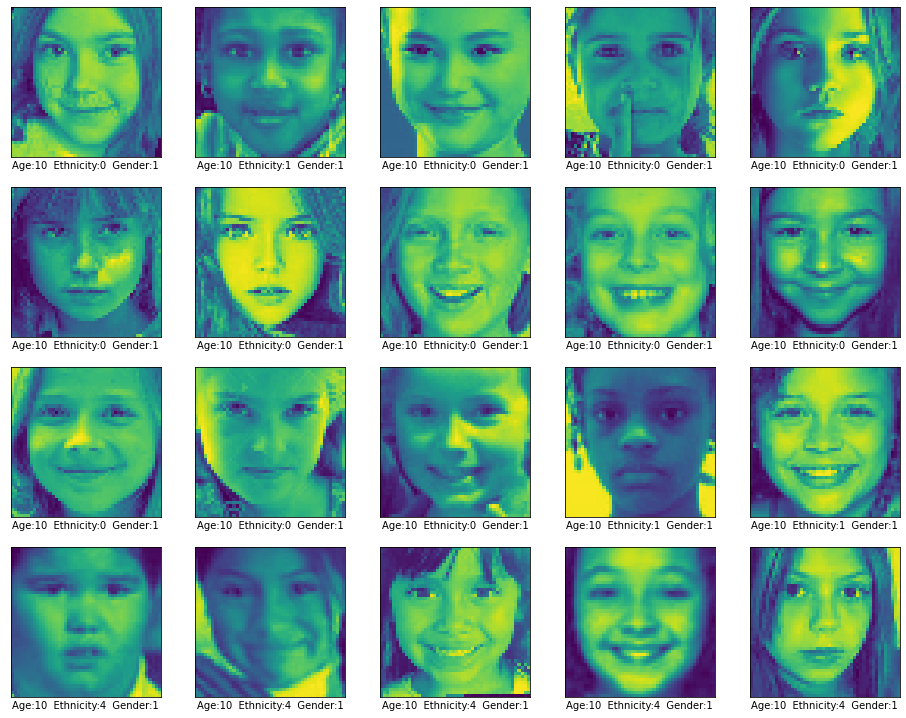

In [13]:
plt.figure(figsize=(16,16))
for i in range(1200,1220):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )
plt.show()

# **CNN Model for Gender Prediction**

### Split data into train/test <a id="4.1"></a>

In [14]:
y = data['gender']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="4.2"></a>

In [15]:
model1 = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                        

In [16]:
history_age = model1.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
260/260 [==============================] - 60s 228ms/step - loss: 0.5354 - accuracy: 0.7295 - val_loss: 0.6088 - val_accuracy: 0.7734
Epoch 2/20
260/260 [==============================] - 58s 224ms/step - loss: 0.4041 - accuracy: 0.8180 - val_loss: 0.4371 - val_accuracy: 0.8075
Epoch 3/20
260/260 [==============================] - 61s 236ms/step - loss: 0.3588 - accuracy: 0.8401 - val_loss: 0.3377 - val_accuracy: 0.8529
Epoch 4/20
260/260 [==============================] - 56s 216ms/step - loss: 0.3321 - accuracy: 0.8517 - val_loss: 0.3212 - val_accuracy: 0.8621
Epoch 5/20
260/260 [==============================] - 62s 238ms/step - loss: 0.3164 - accuracy: 0.8631 - val_loss: 0.3112 - val_accuracy: 0.8637
Epoch 6/20
260/260 [==============================] - 56s 215ms/step - loss: 0.3037 - accuracy: 0.8686 - val_loss: 0.3093 - val_accuracy: 0.8610
Epoch 7/20
260/260 [==============================] - 56s 217ms/step - loss: 0.2978 - accuracy: 0.8697 - val_loss: 0.3006 - val_ac

### Evaluate training history <a id="4.3"></a>

In [17]:
fig = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [18]:
loss1, acc1 = model1.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss1))
print('Test Accuracy: {}'.format(acc1))

Test loss: 0.2589429020881653
Test Accuracy: 0.8863113522529602


# **RNN Model for Gender Prediction**

### Split data into training and testing

In [19]:
y = data['gender']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model

In [20]:
from keras.layers import Dropout
from keras.layers import  Dense, Embedding, LSTM, Bidirectional

In [21]:
vocabulary_size = 48     
embedding_dim = 12 
model_2 = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Flatten(),
    L.Embedding(vocabulary_size, embedding_dim, input_shape=(48,48)),
    L.Bidirectional(LSTM(12)),
    L.Dropout(rate=0.5),
    L.Dense(24, activation='sigmoid'),
    L.Dense(1,activation='sigmoid')
])
model_2.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True
callback = myCallback()
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 embedding (Embedding)       (None, 2304, 12)          576       
                                                                 
 bidirectional (Bidirectiona  (None, 24)               2400      
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                      

In [23]:
history_age2 = model_2.fit(
    X_train, y_train, epochs=5, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/5
260/260 [==============================] - 389s 1s/step - loss: 0.7031 - accuracy: 0.5008 - val_loss: 0.6918 - val_accuracy: 0.5268
Epoch 2/5
260/260 [==============================] - 384s 1s/step - loss: 0.6922 - accuracy: 0.5241 - val_loss: 0.6918 - val_accuracy: 0.5268
Epoch 3/5
260/260 [==============================] - 376s 1s/step - loss: 0.6922 - accuracy: 0.5241 - val_loss: 0.6919 - val_accuracy: 0.5268
Epoch 4/5
260/260 [==============================] - 379s 1s/step - loss: 0.6922 - accuracy: 0.5241 - val_loss: 0.6917 - val_accuracy: 0.5268
Epoch 5/5
260/260 [==============================] - 376s 1s/step - loss: 0.6922 - accuracy: 0.5241 - val_loss: 0.6917 - val_accuracy: 0.5268


### Evaluating training history

In [24]:
fig = px.line(
    history_age2.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [26]:
loss2, acc2 = model_2.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss2))
print('Test Accuracy: {}'.format(acc2))

Test loss: 0.6929293870925903
Test Accuracy: 0.5168711543083191


# **Comparison of the two models**

### Loss Comparison

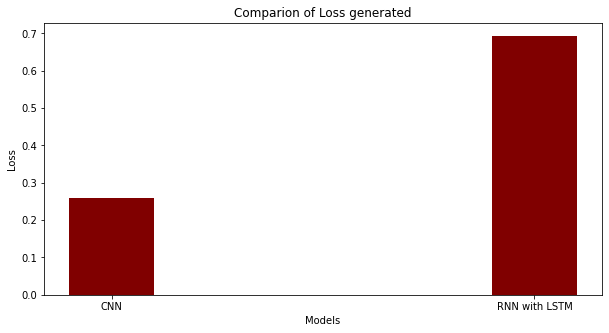

In [27]:
loss = [loss1, loss2]
models = ['CNN', 'RNN with LSTM']
fig = plt.figure(figsize = (10, 5))
plt.bar(models, loss, color ='maroon',
        width = 0.2)
 
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Comparion of Loss generated")
plt.show()

### Accuracy comparison

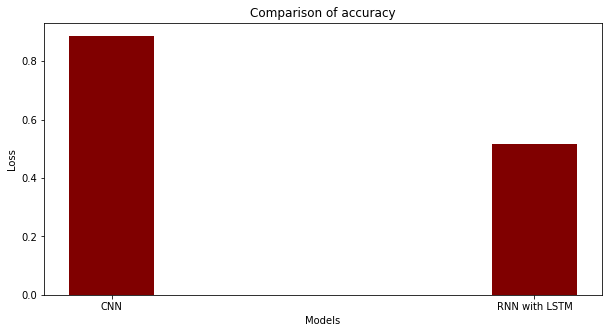

In [28]:
accuracy = [acc1, acc2]
models = ["CNN", "RNN with LSTM"]
fig = plt.figure(figsize = (10, 5))
plt.bar(models, accuracy, color ='maroon',
        width = 0.2)
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Comparison of accuracy")
plt.show()

# **Models for Age prediction**

# **CNN Model for Age prediction**

### Split data into train/test <a id="6.1"></a>

In [29]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="6.2"></a>

In [30]:
model3 = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

model3.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


## Stop training when validation loss reach 110
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()


model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                      

In [31]:
history3 = model3.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
260/260 [==============================] - 69s 263ms/step - loss: 333.0560 - mae: 13.9185 - val_loss: 1092.3511 - val_mae: 27.1980
Epoch 2/20
260/260 [==============================] - 66s 255ms/step - loss: 198.6328 - mae: 10.6444 - val_loss: 502.9794 - val_mae: 17.1490
Epoch 3/20
260/260 [==============================] - 67s 256ms/step - loss: 164.1415 - mae: 9.6218 - val_loss: 133.1310 - val_mae: 8.5623
Epoch 4/20
260/260 [==============================] - 68s 263ms/step - loss: 153.0076 - mae: 9.2144 - val_loss: 127.7266 - val_mae: 8.1612
Epoch 5/20
260/260 [==============================] - 67s 256ms/step - loss: 150.0498 - mae: 9.1009 - val_loss: 120.4612 - val_mae: 8.0542
Epoch 6/20
260/260 [==============================] - 68s 262ms/step - loss: 132.0890 - mae: 8.5055 - val_loss: 123.3694 - val_mae: 8.5678
Epoch 7/20
260/260 [==============================] - ETA: 0s - loss: 125.5112 - mae: 8.2767
Reached 110 val_loss so cancelling training!
260/260 [==============

### Evaluate training history <a id="6.3"></a> 

In [37]:
fig = px.line(
    history3.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [33]:
mse1, mae1 = model3.evaluate(X_test,y_test,verbose=0)
rmse1 = np.sqrt(mse1)
print('Test Mean squared error: {}'.format(mse1))
print('Test Mean absolute error: {}'.format(mae1))
print('Test Root mean squared error: {}'.format(rmse1))

Test Mean squared error: 101.03685760498047
Test Mean absolute error: 7.5271782875061035
Test Root mean squared error: 10.051709188241594


# **RNN model for Age Prediction**

In [34]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

## **Build and train model**<a id="6.3"></a>

In [35]:
vocabulary_size = 48     
embedding_dim = 12        
model4 = tf.keras.Sequential([
  L.InputLayer(input_shape=(48,48,1)),
  L.Flatten(),
  L.Embedding(vocabulary_size, embedding_dim, input_shape=(48,48)),
  L.GRU(12),
  L.Dense(64, activation='relu',input_shape=(48, 48)),
  L.Dropout(0.2),
  L.Dense(5, activation='relu')
])

model4.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


## Stop training when validation loss reach 110
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2304)              0         
                                                                 
 embedding_1 (Embedding)     (None, 2304, 12)          576       
                                                                 
 gru (GRU)                   (None, 12)                936       
                                                                 
 dense_6 (Dense)             (None, 64)                832       
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2,669
Trainable params: 2,669
Non-traina

In [36]:
history_4 = model4.fit(
    X_train, y_train, epochs=5, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/5
260/260 [==============================] - 241s 919ms/step - loss: 965.0621 - mae: 24.6728 - val_loss: 515.9121 - val_mae: 17.3673
Epoch 2/5
260/260 [==============================] - 232s 894ms/step - loss: 419.8175 - mae: 15.7619 - val_loss: 410.9612 - val_mae: 15.4428
Epoch 3/5
260/260 [==============================] - 237s 911ms/step - loss: 404.5070 - mae: 15.4871 - val_loss: 410.7066 - val_mae: 15.4577
Epoch 4/5
260/260 [==============================] - 235s 903ms/step - loss: 405.8113 - mae: 15.5045 - val_loss: 412.2664 - val_mae: 15.3703
Epoch 5/5
260/260 [==============================] - 236s 907ms/step - loss: 403.8784 - mae: 15.4823 - val_loss: 411.2592 - val_mae: 15.4092


In [38]:
mse2, mae2 = model4.evaluate(X_test,y_test,verbose=0)
rmse2 = np.sqrt(mse2)
print('Test Mean squared error: {}'.format(mse2))
print('Test Mean absolute error: {}'.format(mae2))
print('Test Root mean squared error: {}'.format(rmse2))

Test Mean squared error: 397.44775390625
Test Mean absolute error: 15.199275970458984
Test Root mean squared error: 19.936091741017094


In [39]:
fig = px.line(
    history_4.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

# Comparison for CNN and RNN models for Age Prediction

### Mean Squared error

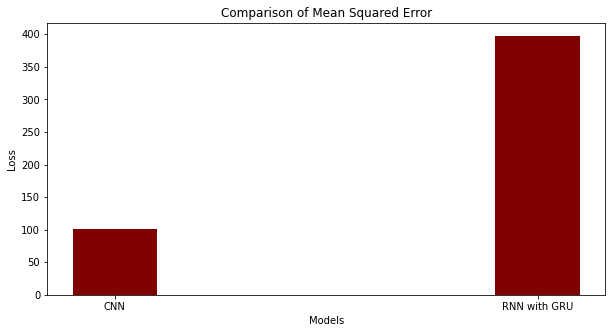

In [40]:
mse = [mse1, mse2]
models = ["CNN", "RNN with GRU"]
fig = plt.figure(figsize = (10, 5))
plt.bar(models, mse, color ='maroon',
        width = 0.2)
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Comparison of Mean Squared Error")
plt.show()

### Mean absolute error

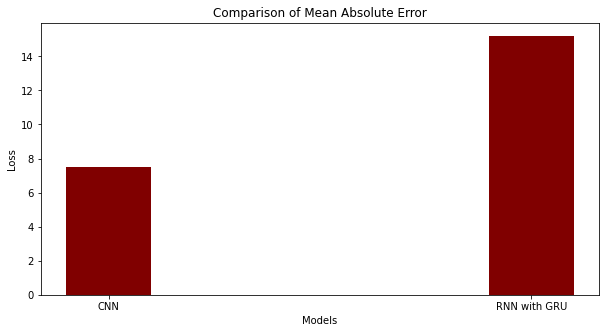

In [41]:
mae = [mae1, mae2]
models = ["CNN", "RNN with GRU"]
fig = plt.figure(figsize = (10, 5))
plt.bar(models, mae, color ='maroon',
        width = 0.2)
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Comparison of Mean Absolute Error")
plt.show()

### Root Mean Squared error

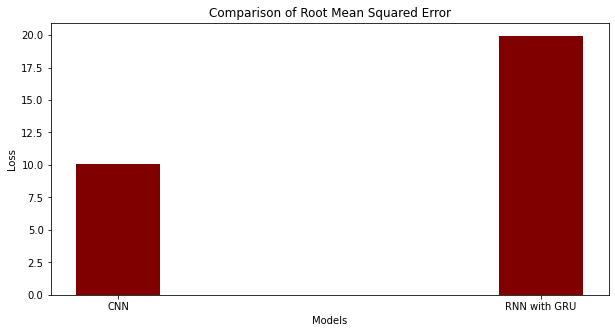

In [42]:
rmse = [rmse1, rmse2]
models = ["CNN", "RNN with GRU"]
fig = plt.figure(figsize = (10, 5))
plt.bar(models, rmse, color ='maroon',
        width = 0.2)
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Comparison of Root Mean Squared Error")
plt.show()